<a href="https://colab.research.google.com/github/AmedeeRoy/BirdDL/blob/main/Dive_Prediction_1D_NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting Seabird Diving Behaviour with GPS data

Supervized Learning with Deep Networks


In [1]:
# general material
import numpy as np
import matplotlib.pyplot as plt
import pickle

# pytorch materials
import torch
from torch import nn
from torch import optim
import torchvision as tv
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

In [2]:
# Hyperparameters
batch_size = 8
learning_rate = 0.001

In [4]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [5]:
### LOAD DATA ### --------------------------

fileObj = open('/content/drive/My Drive/data/train_dives.obj', 'rb')
train_trajs_balanced = pickle.load(fileObj)
fileObj.close()

fileObj = open('/content/drive/My Drive/data/test_dives.obj', 'rb')
test_trajs = pickle.load(fileObj)
fileObj.close()

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = [(torch.tensor(x.T, dtype = torch.float), torch.tensor([y], dtype = torch.float)) for (x,y) in train_trajs_balanced]
test_dataset = [(torch.tensor(x.T, dtype = torch.float), torch.tensor([y], dtype = torch.float)) for (x,y) in test_trajs]

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [7]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(2, 2, kernel_size = 26, stride = 1, padding = 25, dilation = 2),
            nn.Conv1d(2, 1, kernel_size = 26, stride = 1, padding = 25, dilation = 2),
            nn.Sigmoid(),
            nn.MaxPool1d(kernel_size = 26, stride = 1, padding = 10, dilation = 2),
            nn.Linear(70, 50))
        
        self.layer2 = nn.Sequential(
            nn.Conv1d(1, 1, kernel_size = 11, stride = 1, padding = 10, dilation = 2),
            nn.Conv1d(1, 1, kernel_size = 11, stride = 1, padding = 10, dilation = 2),
            nn.Sigmoid(),
            nn.MaxPool1d(kernel_size = 5, padding = 2, dilation = 2),
            nn.Linear(10, 1))
               
        self.sigmoid = nn.Sigmoid()
        
        self.layer = nn.Sequential(
            nn.Conv1d(1, 1, kernel_size = 11, stride = 1, padding = 10, dilation = 2),
            nn.Conv1d(1, 1, kernel_size = 11, stride = 1, padding = 10, dilation = 2),
            nn.Sigmoid(),
            nn.MaxPool1d(kernel_size = 5, padding = 2, dilation = 2)
        )
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.sigmoid(out)
        out = out.reshape((batch_size, 1))
        return out

In [8]:
inputs = [x for batch, (x,y) in enumerate(train_loader)]
outputs = [y for batch, (x,y) in enumerate(train_loader)]
outputs[0].size()

torch.Size([8, 1])

In [9]:
model = ConvNet()
out = model(inputs[0])
out.size()

torch.Size([8, 1])

In [10]:
model(inputs[0])

tensor([[0.3949],
        [0.3953],
        [0.3951],
        [0.3952],
        [0.3950],
        [0.3950],
        [0.3951],
        [0.3953]], grad_fn=<ViewBackward>)

In [11]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [12]:
criterion(outputs[0], torch.autograd.Variable(model(inputs[0])))

tensor(44.7482)

In [13]:
# Train the model
total_step = len(train_loader)
loss_list = []
acc_list = []

for i, (x, y) in enumerate(train_loader):
    
    # Train the model
    model.train()
    
    # Run the forward pass
    outputs = model(x)
    loss = criterion(outputs, torch.autograd.Variable(y))

    # Backprop and perform optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

    if (i + 1) % 1000 == 0:  
        # Test the model
        model.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for x, y in test_loader:
                outputs = model(x)
                
                # dive prediction
                correct += torch.sum(1*(outputs>0.5) == y).item()
                total += batch_size
        
#         # Plot weight
#         IPython.display.clear_output(wait=True)

#         plt.figure(figsize=(16, 4))
#         jj = 0    
#         for name, param in model.named_parameters():
#             if param.requires_grad:
#                 jj+=1
#                 plt.subplot(4, 4, jj)
#                 plt.hist(param.data.numpy().reshape(np.prod(param.data.numpy().shape)))
#                 plt.title(name)
        
#         plt.show()
        print('Step [{}/{}], Loss: {:.4f}, Accuracy: {} %'
              .format(i + 1, total_step, loss.item(), (correct / total) * 100))

Step [1000/84575], Loss: 0.5677, Accuracy: 76.3733859906352 %
Step [2000/84575], Loss: 0.8166, Accuracy: 76.3733859906352 %
Step [3000/84575], Loss: 0.8347, Accuracy: 76.3733859906352 %
Step [4000/84575], Loss: 0.4235, Accuracy: 76.3733859906352 %
Step [5000/84575], Loss: 0.4172, Accuracy: 76.3733859906352 %
Step [6000/84575], Loss: 0.5610, Accuracy: 76.3733859906352 %
Step [7000/84575], Loss: 0.7086, Accuracy: 76.3733859906352 %
Step [8000/84575], Loss: 0.5598, Accuracy: 76.3733859906352 %
Step [9000/84575], Loss: 0.5647, Accuracy: 76.3733859906352 %
Step [10000/84575], Loss: 0.4087, Accuracy: 76.3733859906352 %
Step [11000/84575], Loss: 0.4154, Accuracy: 76.3733859906352 %
Step [12000/84575], Loss: 0.5555, Accuracy: 76.3733859906352 %
Step [13000/84575], Loss: 0.5575, Accuracy: 76.3733859906352 %
Step [14000/84575], Loss: 0.6756, Accuracy: 76.3733859906352 %
Step [15000/84575], Loss: 0.2680, Accuracy: 76.3733859906352 %
Step [16000/84575], Loss: 0.5514, Accuracy: 76.3733859906352 %
S

In [14]:
i = 0
for x, y in test_loader:
    i += 1
    outputs = model(x)
    
    if i == 10:
        break
    # dive prediction
    correct += torch.sum(1*(outputs>0.5) == y).item()
    total += batch_size

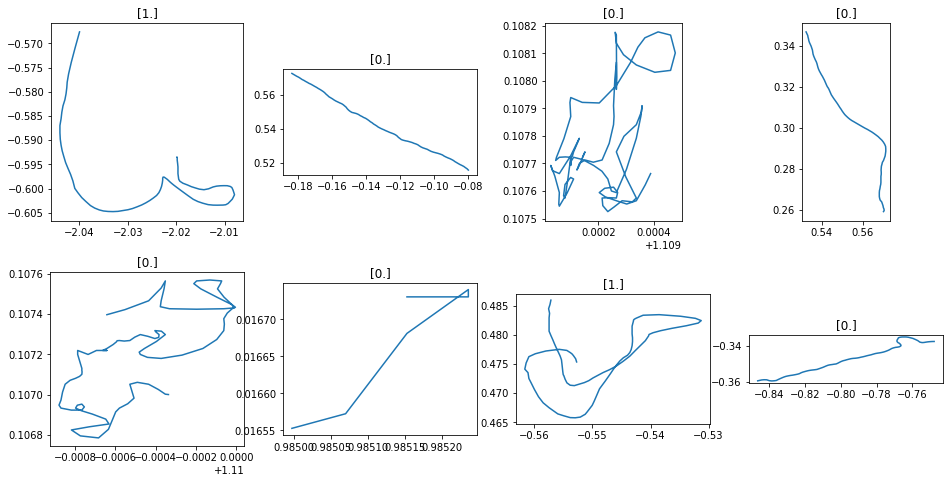

In [15]:
plt.figure(figsize=(16, 8))

for i in range(8):
# i = 0
    plt.subplot(2, 4, i+1)
    plt.plot(x.numpy()[i][0], x.numpy()[i][1])
    plt.title(str(y.numpy()[i]))
    
        #selecting the current axis
    ax = plt.gca()
    ax.set_aspect(1)

In [16]:
outputs

tensor([[0.3869],
        [0.3409],
        [0.0493],
        [0.1124],
        [0.0493],
        [0.0528],
        [0.3792],
        [0.3859]], grad_fn=<ViewBackward>)

In [17]:
y

tensor([[1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.]])